# 사이킷런 파이프라인(Pipeline)

In [1]:
# 명령 결과 모두 보기
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# 버전 경고 무시
import warnings
warnings.filterwarnings('ignore')

# 판다스와 넘피
import pandas as pd
import numpy as np

# 그림 그리기
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams['font.family']='Malgun Gothic' # 한글폰트

In [2]:
def summary(df) :
    tf = pd.DataFrame({'데이터형태(dtypes)' : df.dtypes,
                       '비 결측치 수(notnull': df.notnull().sum(),
                       '결측치 수(null)' : df.isnull().sum(),
                       '고유값 수(nunique)' : df.nunique()})
    return tf

## 1. Obtaining the Data

In [3]:
df = sns.load_dataset('titanic')
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


### 1.1 데이터전처리

In [4]:
df['farebin'] = pd.qcut(df['fare'], q=3, labels = ['low', 'middle', 'high'])
df.drop(['pclass', 'who', 'adult_male', 'deck', 'embark_town', 'alive', 'alone'], axis=1, inplace=True)

In [5]:
summary(df)

,데이터형태(dtypes),비 결측치 수(notnull,결측치 수(null),고유값 수(nunique)
survived,int64,891,0,2
sex,object,891,0,2
age,float64,714,177,88
sibsp,int64,891,0,7
parch,int64,891,0,7
fare,float64,891,0,248
embarked,object,889,2,3
class,category,891,0,3
farebin,category,891,0,3


### 1.1 Randomly assign 10% of observations to be missing

In [6]:
missing_features = df.loc[:, ['parch', 'fare']]
missing_features = missing_features.mask(np.random.random(missing_features.shape) < .1)
missing_features.isnull().values.any()

True

In [7]:
df[missing_features.columns] = missing_features
summary(df)

,데이터형태(dtypes),비 결측치 수(notnull,결측치 수(null),고유값 수(nunique)
survived,int64,891,0,2
sex,object,891,0,2
age,float64,714,177,88
sibsp,int64,891,0,7
parch,float64,815,76,7
fare,float64,811,80,236
embarked,object,889,2,3
class,category,891,0,3
farebin,category,891,0,3


### 1.2 train_test data preparation

In [8]:
features = df.drop(['survived'], axis=1)
target = df['survived']

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size= 0.2, random_state= 0)

## 2. Setting up the Pipeline

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

### 2.1 Numeric Data

In [50]:
num_steps = [
    ('imputer', SimpleImputer(strategy='median')),
    ('standardize', StandardScaler())
]

num_transformer = Pipeline(steps=num_steps)

### 2.2 Ordinal Data

In [12]:
ord_steps = [
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoding', OrdinalEncoder())
]

ord_transformer = Pipeline(steps=ord_steps)

### 2.3 Categorical Data

In [13]:
ohe_steps = [
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoding', OneHotEncoder(handle_unknown='ignore'))
]

ohe_transformer = Pipeline(steps=ohe_steps)

## 3. Fitting The Pipeline

In [14]:
summary(df)

,데이터형태(dtypes),비 결측치 수(notnull,결측치 수(null),고유값 수(nunique)
survived,int64,891,0,2
sex,object,891,0,2
age,float64,714,177,88
sibsp,int64,891,0,7
parch,float64,805,86,7
fare,float64,814,77,234
embarked,object,889,2,3
class,category,891,0,3
farebin,category,891,0,3


Split up the columns by data type for separate preprocessing

In [14]:
features.columns[(features.dtypes == 'float64') | (features.dtypes == 'int64')]

Index(['age', 'sibsp', 'parch', 'fare'], dtype='object')

In [17]:
num_cols = features.columns[(features.dtypes == 'float64') | (features.dtypes == 'int64')]
ord_cols = features.columns[features.dtypes == 'category']
ohe_cols = features.columns[features.dtypes == 'object']

# steps for the transformation
transformer_steps = [
    ('num', num_transformer, num_cols),
    ('ord', ord_transformer, ord_cols),
    ('ohe', ohe_transformer, ohe_cols)
]

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, classification_report

In [19]:
steps = [
    ('transformation', ColumnTransformer(transformers=transformer_steps)),
    ('linreg', LogisticRegression())
]

pipe = Pipeline(steps=steps)

## 4. Fit a regression model to data

In [20]:
lm = pipe.fit(X_train, y_train)

In [21]:
lm.named_steps['linreg']
lm.named_steps['linreg'].coef_

LogisticRegression()

array([[-0.56208909, -0.41652308, -0.10901514,  0.05499259, -0.97787188,
        -0.14325615,  1.33950716, -1.33939515, -0.00387784,  0.09330036,
        -0.28806205,  0.19875154]])

In [22]:
from sklearn.metrics import plot_confusion_matrix, classification_report

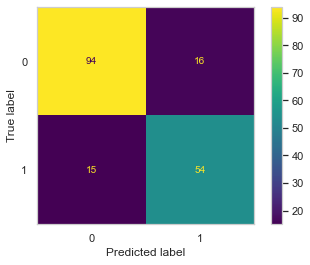

In [23]:
sns.set_style("whitegrid", {'axes.grid' : False})
plot_confusion_matrix(lm, X_test, y_test)

In [24]:
y_predict = lm.predict(X_test)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.86      0.85      0.86       110
           1       0.77      0.78      0.78        69

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



## 5. Randomizedgridsearch with cross validation

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import (KFold, RandomizedSearchCV)
kf = KFold(n_splits=3)

In [27]:
steps = [
    ('transformation', ColumnTransformer(transformers=transformer_steps)),
    ('knn', KNeighborsClassifier())
]

pipe = Pipeline(steps=steps)

In [31]:
params = {'knn__n_neighbors' : list(range(5,105, 4)),
              'knn__weights' : ['uniform','distance'],
              'knn__algorithm': ['ball_tree', 'kd_tree'],
              'knn__leaf_size' : list(range(5,50)),
              'knn__p' : [1, 2]
             }

In [32]:
grid = RandomizedSearchCV(pipe, 
                          param_distributions=params, 
                          cv=kf,
                          n_iter=10, 
                          scoring='recall_macro', verbose=True
                          )
grid.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.8s finished


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('transformation',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('standardize',
                                                                                                StandardScaler())]),
                                                                               Index(['age', 'sibsp', 'parch', 'fare'], dtype='object')),
                                                                              ('ord',
                                                                               Pipeli

In [33]:
print('optimal train score: {:.3f}'.format(grid.best_score_))
print('optimal test score: {:.3f}'.format(grid.score(X_test, y_test)))
print('optimal parameter: {}'.format(grid.best_params_))

optimal train score: 0.774
optimal test score: 0.784
optimal parameter: {'knn__weights': 'uniform', 'knn__p': 1, 'knn__n_neighbors': 9, 'knn__leaf_size': 35, 'knn__algorithm': 'kd_tree'}


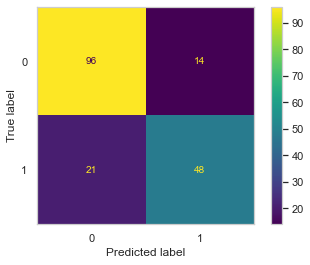

In [34]:
sns.set_style("whitegrid", {'axes.grid' : False})
plot_confusion_matrix(grid, X_test, y_test) # plot_confusion_matrix(grid.best_estimator_, X_test, y_test)

In [35]:
y_predict = grid.predict(X_test)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.82      0.87      0.85       110
           1       0.77      0.70      0.73        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



### A. AUROC
   * FPR(FP/N)에 대한 TPR(TP/P) 비율 의미 : 즉 허위양성판정비율에 대한 참 양성 판정비율을 모두 integral한 값

(array([19., 39., 30., 17., 12., 13., 10.,  8., 17., 14.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

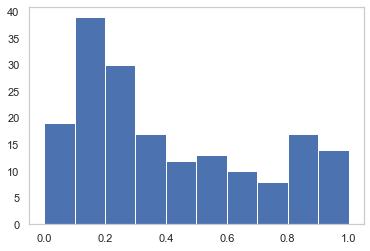

In [36]:
y_proba = grid.predict_proba(X_test)
plt.hist(y_proba[:, 1]) 

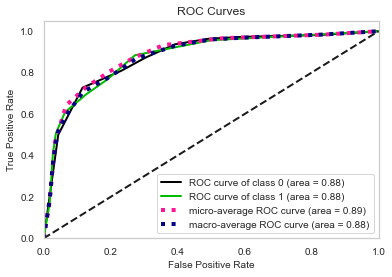

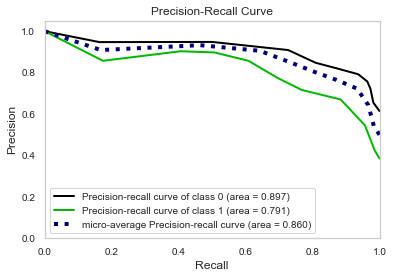

In [37]:
import scikitplot as skplt 
skplt.metrics.plot_roc(y_test, y_proba)
skplt.metrics.plot_precision_recall(y_test, y_proba)

In [39]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_proba[:, 1])

0.8774703557312253

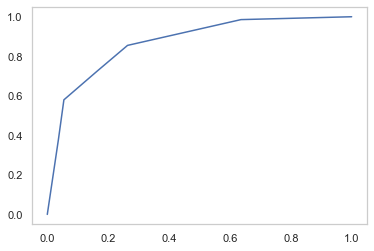

In [33]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1])
plt.plot(fpr, tpr)

### B. Calibration plot
- Python’s «predict_proba» Doesn’t Actually Predict Probabilities (and How to Fix It)
- https://scikit-learn.org/stable/auto_examples/calibration/plot_compare_calibration.html#sphx-glr-auto-examples-calibration-plot-compare-calibration-py
- https://towardsdatascience.com/pythons-predict-proba-doesn-t-actually-predict-probabilities-and-how-to-fix-it-f582c21d63fc

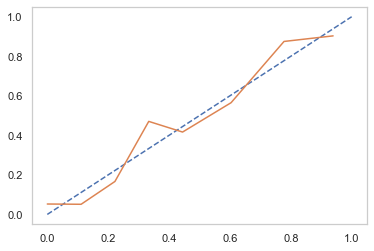

In [40]:
from sklearn.calibration import calibration_curve
y_means, proba_means = calibration_curve(y_test.values.reshape(-1,1), y_proba[:, 1], n_bins = 10, strategy= 'quantile')
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfect calibration')
plt.plot(proba_means, y_means)

#### B-1. fix method - 1

In [41]:
from sklearn.isotonic import IsotonicRegression
iso_reg = IsotonicRegression(y_min = 0, y_max = 1, out_of_bounds = 'clip').fit(y_proba[:, 1], y_test)
proba_test_isoreg = iso_reg.predict(grid.predict_proba(X_test)[:, 1])

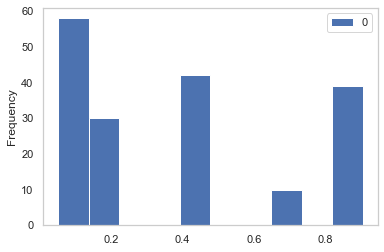

In [42]:
pd.DataFrame(proba_test_isoreg).plot(kind='hist')

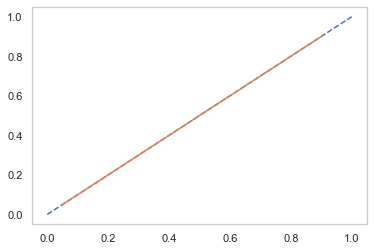

In [43]:
y_means, proba_means = calibration_curve(y_test.values.reshape(-1,1), proba_test_isoreg, n_bins = 10, strategy= 'quantile')
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfect calibration')
plt.plot(proba_means, y_means)

#### B-2. fix method - 2

In [44]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression().fit(y_proba[:, 1].reshape(-1,1), y_test)

In [45]:
proba_test_logreg = log_reg.predict_proba(grid.predict_proba(X_test)[:, 1].reshape(-1, 1))[:, 1]

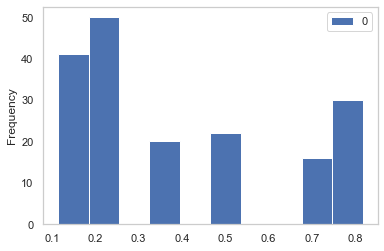

In [46]:
pd.DataFrame(proba_test_logreg).plot(kind='hist')

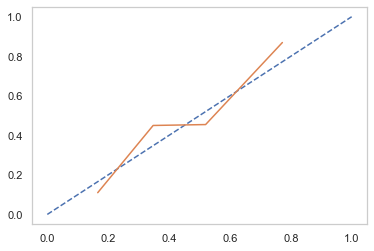

In [49]:
y_means, proba_means = calibration_curve(y_test.values.reshape(-1,1), proba_test_logreg, strategy= 'quantile')
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfect calibration')
plt.plot(proba_means, y_means)

### C. KS-Plot

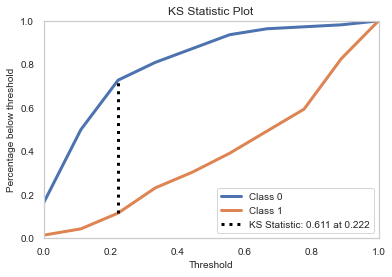

In [44]:
skplt.metrics.plot_ks_statistic(y_test, y_proba)

### D. learning curve

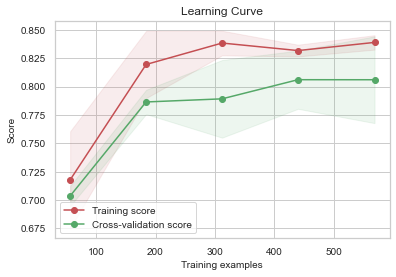

In [45]:
skplt.estimators.plot_learning_curve(grid.best_estimator_, X_train, y_train)

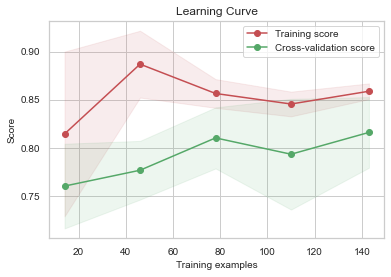

In [65]:
skplt.estimators.plot_learning_curve(grid.best_estimator_, X_test, y_test)

### E. brier score

In [46]:
from sklearn.metrics import brier_score_loss
brier_score_loss(y_test, y_proba[:,1])

0.13504379612387063

## <font color='blue'>6. Breaking Into the Pipeline

In [47]:
from sklearn import set_config
set_config(display='diagram')
pipe

Pipeline(steps=[('transformation',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  Index(['age', 'sibsp', 'parch', 'fare'], dtype='object')),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoding',
                                                                   OrdinalEncoder())]),
                                                  Index(['class', 'farebin'], dtype='object')),
                                                 ('ohe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoding',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['sex', 'embarked'], dtype='object'))])),
                ('knn', KNeighborsClassifier())])

In [48]:
lm.named_steps

{'transformation': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='median')),
                                                  ('standardize',
                                                   StandardScaler())]),
                                  Index(['age', 'sibsp', 'parch', 'fare'], dtype='object')),
                                 ('ord',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='most_frequent')),
                                                  ('encoding',
                                                   OrdinalEncoder())]),
                                  Index(['class', 'farebin'], dtype='object')),
                                 ('ohe',
                                  Pipeline(steps=[('imputer',
                                                

### 6.1 Obtain Imputation Values For Numeric and Ordinal Data

In [55]:
lm.named_steps['transformation'].named_transformers_['num']['imputer']

SimpleImputer(strategy='median')

In [56]:
lm.named_steps['transformation'].named_transformers_['num']['imputer'].statistics_

array([29. ,  0. ,  0. , 14.5])

In [57]:
lm.named_steps['transformation'].named_transformers_['ord']['imputer'].statistics_

array(['Third', 'low'], dtype=object)

### 6.2 Obtain Mean and Variance Used For Standardization

In [58]:
lm.named_steps['transformation'].named_transformers_['num']['standardize'].mean_
lm.named_steps['transformation'].named_transformers_['num']['standardize'].var_

array([29.59761236,  0.52949438,  0.35955056, 30.19022598])

array([1.71181463e+02, 1.29969188e+00, 6.26341371e-01, 2.12375865e+03])

### 6.3 Extract Feature Names for Numeric and Ordinal Columns

In [59]:
lm.named_steps['transformation'].transformers_

[('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                  ('standardize', StandardScaler())]), Index(['age', 'sibsp', 'parch', 'fare'], dtype='object')),
 ('ord', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                  ('encoding', OrdinalEncoder())]), Index(['class', 'farebin'], dtype='object')),
 ('ohe', Pipeline(steps=[('imputer',
                   SimpleImputer(fill_value='missing', strategy='constant')),
                  ('encoding', OneHotEncoder(handle_unknown='ignore'))]), Index(['sex', 'embarked'], dtype='object'))]

Numeric Column

In [60]:
lm.named_steps['transformation'].transformers_[0][2]

Index(['age', 'sibsp', 'parch', 'fare'], dtype='object')

Ordinal Column

In [61]:
lm.named_steps['transformation'].transformers_[1][2]

Index(['class', 'farebin'], dtype='object')

### 6.4 Extract Feature Names for One-Hot Encoded Columns

In [62]:
lm.named_steps['transformation'].transformers_[2][1].named_steps['encoding']

OneHotEncoder(handle_unknown='ignore')

In [63]:
lm.named_steps['transformation'].transformers_[2][1].named_steps['encoding'].get_feature_names()

array(['x0_female', 'x0_male', 'x1_C', 'x1_Q', 'x1_S', 'x1_missing'],
      dtype=object)

In [64]:
lm.named_steps['transformation'].transformers_[2][1].named_steps['encoding'].get_feature_names(ohe_cols)

array(['sex_female', 'sex_male', 'embarked_C', 'embarked_Q', 'embarked_S',
       'embarked_missing'], dtype=object)

# End